In [24]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
from torch.autograd import Variable, grad


In [25]:
class PhysicsInformedNN(nn.Module):

  def __init__(self, layers_u, layers_K, num_pumps=25):
    super(PhysicsInformedNN, self).__init__()
  
    self.layers = layers
  
    self.weights_u, self.biases_u = [], []
    self.weights_K, self.biases_K = self.initialize_NN(layers_K)   
    self.weights = []
    self.biases = []

    self.preds = None

    self.loss = 0.0
    self.loss_list = []   
    self.loss_container = []

    for i in range(num_pumps): 
      loss_dict = {'neum':[0.0], 'diri':[0.0],'u':[0.0],'f':[0.0],'K':[0.0],'around':[0.0],'pump':[0.0]}
      self.loss_container.append(loss_dict)
      w, b = self.initialize_NN(layers_u)
      self.weights_u.append(w)
      self.biases_u.append(b)
    
      self.weights += w
      self.biases += b
    self.weights += self.weights_K
    self.biases += self.biases_K

  def initialize_NN(self, layers):        
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
      W = self.xavier_init(size=[layers[l], layers[l+1]])
      b = Variable(torch.zeros([1,layers[l+1]], dtype=torch.float32), requires_grad=True)
      weights.append(W)
      biases.append(b)        
    return weights, biases
      
  def xavier_init(self, size):
    return Variable(nn.init.xavier_normal_(torch.empty(size[0], size[1])), requires_grad=True)
    
  def load_NN(self, layers, params):
    weights = []
    biases = []
    params = torch.tensor(params,dtype=torch.float32)
    num_layers = len(layers)
    i = 1
    for l in range(0,num_layers-2):
      W = torch.zeros([layers[l], layers[l+1]], dtype=torch.float32)
      b = torch.zeros([1,layers[l+1]], dtype=torch.float32)
      W = W + params[i:i+layers[l]]
      b = b + params[i+layers[l]]
      i = i + layers[l] + 1
      weights.append(Variable(W, requires_grad=True))
      biases.append(Variable(b, requires_grad=True))

    output_layer_w = Variable(params[i][:,None], requires_grad=True)
    
    output_layer_b = torch.zeros((1,1), dtype=torch.float32)
    output_layer_b = output_layer_b + params[i+1,0]

    weights.append(output_layer_w)
    biases.append(Variable(output_layer_b,requires_grad=True))

    return weights, biases

  def neural_net(self, x, y, weights, biases):

    num_layers = len(weights) + 1
    H = torch.cat((x,y),1)
    for l in range(0,num_layers-2):
      W = weights[l]
      b = biases[l]
      H = torch.tanh(torch.add(torch.matmul(H, W), b))

    W = weights[-1]
    b = biases[-1]
    Y = torch.add(torch.matmul(H, W), b)

    return Y

  def net_u(self, x, y, weights, biases): # water head u
    u = self.neural_net(x, y, weights, biases)
    return u
  
  def net_K(self, x, y): # hydraulic conductivity K
    K = self.neural_net(x, y, self.weights_K, self.biases_K)
    return K
  
  def get_loc_idx(self, x, y):
    x = x.detach().numpy()
    y = y.detach().numpy()

    x_arr = np.linspace(-1,1,self.given_K.shape[0])
    y_arr = np.linspace(-1,1,self.given_K.shape[1])

    xsorted = np.argsort(x_arr)
    xpos = np.searchsorted(x_arr[xsorted], x)
    r = xsorted[xpos]

    ysorted = np.argsort(y_arr)
    ypos = np.searchsorted(y_arr[ysorted], y)
    c = xsorted[ypos]

    return (r, c)


  def net_du(self, x, y, weights, biases): # first-order derivative of u

    u = self.net_u(x, y, weights, biases)

    u_x = grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
    u_y = grad(u.sum(), y, create_graph=True)[0]

    return u_x.requires_grad_(True), u_y.requires_grad_(True)

  def net_dK(self, x, y): # first-order derivative of K
    K = self.net_K(x, y)

    K_x = grad(K.sum(), x, create_graph=True)[0]
    K_y = grad(K.sum(), y, create_graph=True)[0]

    return K_x.requires_grad_(True), K_y.requires_grad_(True)


  def net_f(self, x, y, weights, biases): # general PDE net

    u_x, u_y = self.net_du(x, y, weights, biases)
    u_yy = grad(u_y.sum(), y, create_graph=True)[0]
    u_xx = grad(u_x.sum(), x, create_graph=True)[0]

    K = self.net_K(x, y)
    K_x, K_y = self.net_dK(x, y)

    f = K*(u_yy + u_xx) + K_x*u_x + K_y*u_y

    return f.requires_grad_(True)

  def forward(self, x_tensors, y_tensors, weights, biases, keys=None):

    if keys is None:
      keys = x_tensors.keys()
    else:
      preds = dict()
      for i in keys:
          preds[i] = None

    for i in keys:

      if i == 'neum':
        dudx_pred, dudy_pred = self.net_du(x_tensors[i], y_tensors[i], weights, biases)
        preds[i] = dudy_pred

      elif i == 'f':
        f_pred = self.net_f(x_tensors[i], y_tensors[i], weights, biases)
        preds[i] = f_pred

      elif i == 'u':
        u_pred = self.net_u(x_tensors[i], y_tensors[i], weights, biases) 
        preds[i] = u_pred
          
      elif i == 'K':
        K_pred = self.net_K(x_tensors[i], y_tensors[i])
        preds[i] = K_pred
          
      elif i == 'diri':
        diri_pred = self.net_u(x_tensors[i], y_tensors[i], weights, biases) 
        preds[i] = diri_pred

      elif i == 'pump':
        p_pred = self.net_f(x_tensors[i], y_tensors[i], weights, biases)
        preds[i] = p_pred

    return preds

  def loss_func(self, pred_dict, true_dict, pump_id, weights=None):
  
    loss = torch.tensor(0.0, dtype=torch.float32)
    keys = pred_dict.keys()

    if weights is None:
      weights = dict()
      for i in keys:
        weights[i] = 1.0

    for i in keys:
      res = pred_dict[i] - true_dict[i]
      loss += weights[i]*torch.mean(res.pow(2))
      r = torch.mean(res.pow(2)).item()
      self.loss_container[pump_id][i].append(r*weights[i])
    return loss.requires_grad_()

  def unzip_train_dict(self, train_dict, keys=None):
    if keys is None:
      keys = train_dict.keys()

    x_tensors = dict()
    y_tensors = dict()
    true_dict = dict()

    for i in keys:
      x_tensors[i] = train_dict[i][0]
      y_tensors[i] = train_dict[i][1]
      true_dict[i] = train_dict[i][2]

    return (x_tensors, y_tensors, true_dict)

  def train(self, epoch, data_batch, loss_func, optimizer, pred_keys=None, loss_weights=None, pump_id_list=[0], print_interval=1000):
      
    if pred_keys is None:
      pred_keys= data_batch[0].keys()
    start_time = time.time()
    for i in range(epoch):
      optimizer.zero_grad()
      loss = 0.0
      for pump_id in pump_id_list:
        train_dict = data_batch[pump_id]

        (x_tensors, y_tensors, true_dict) = self.unzip_train_dict(train_dict,pred_keys)
        pred_dict = self.forward(x_tensors, y_tensors, self.weights_u[pump_id], self.biases_u[pump_id], keys=pred_keys)
        loss += loss_func(pred_dict, true_dict, pump_id, loss_weights)

      loss.backward()
      self.callback(loss.detach().numpy().squeeze())

      if np.remainder(len(self.loss_list),print_interval) == 1:
        elapsed = time.time() - start_time
        print('Iter # %d, Loss: %.8f, Time: %.4f' % (len(self.loss_list), self.loss_list[-1], elapsed))
        print_loss = dict()
        for pid in pump_id_list:
          print_loss = "Pump "+ str(pid) + ": "
          for k in ['u','f','K','neum','pump','diri']:
            s = k+":"+str(self.loss_container[pid][k][-1])+"; "
            print_loss += s
          print(print_loss)
        start_time = time.time()  

      optimizer.step()

  def callback(self, loss):
    self.loss_list.append(loss)

  def coor_shift(self, X, lbs, ubs):
    return 2.0*(X - lbs) / (ubs - lbs) - 1

  def data_loader(self, X, u, lbs, ubs):
              
    X = self.coor_shift(X, lbs, ubs)
    x_tensor = torch.tensor(X[:,0:1], requires_grad=True, dtype=torch.float32)
    y_tensor = torch.tensor(X[:,1:2], requires_grad=True, dtype=torch.float32)
    u_tensor = torch.tensor(u, dtype=torch.float32)
    
    return (x_tensor, y_tensor, u_tensor)

  def predict(self, X_input, pid=0, target='u'):
    x_tensor = torch.tensor(X_input[:,0:1], dtype=torch.float32, requires_grad=True)
    y_tensor = torch.tensor(X_input[:,1:2], dtype=torch.float32, requires_grad=True)
    w = self.weights_u[pid]
    b = self.biases_u[pid]
    pred = None
    if target == 'u':
      pred = self.net_u(x_tensor, y_tensor, w, b).detach().numpy().squeeze()
    elif target == 'du':
      dudx, dudy = self.net_du(x_tensor, y_tensor, w, b)
      return dudx.detach().numpy().squeeze(), dudy.detach().numpy().squeeze()
    elif target == 'f':
      pred = self.net_f(x_tensor, y_tensor, w, b).detach().numpy().squeeze()

    elif target == 'K':
      pred = self.net_K(x_tensor, y_tensor).detach().numpy().squeeze()

    return pred


In [26]:
################ hydraulic conductivty field ###################
logK = np.loadtxt('./data/logK_field.txt')
K = np.exp(logK)
(nx,ny) = logK.shape

################ K measurement locations ###################
K_measure_id = np.loadtxt('./data/K_measure_id_61.txt').astype(int)

################ pumping well locations ###################
num_wells = 25
well_id = np.arange(num_wells)
pump_cell_idx = np.loadtxt('./data/pump_well_id_25.txt').astype(int)

################ hydraulic heads under each pumping event ###################
heads = np.empty((nx*ny, num_wells))
for i in range(num_wells):
  head = np.loadtxt('./data/heads/head_pump'+str(i)+'.txt')
  heads[:,i]=head.T.flatten()

In [27]:
############### define domain with (0,0) at center ######
Lox, Loy = 1, 1
dx, dy = Lox/nx, Loy/ny
x = np.arange((-Lox/2+dx/2),(Lox/2),dx)
y = np.arange((-Lox/2+dx/2),(Lox/2),dy)

X, Y = np.meshgrid(x,y)

X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

#################  relax region defination ##################
r = 3  # half-length of relax region
pump_row_idx = np.repeat(pump_cell_idx[:,None],2*r-1,1)
pump_row_idx = pump_row_idx - np.arange(-r+1,r)
around_idx = [pump_row_idx]
for i in range(1,r):
  around_idx = [pump_row_idx-nx*i] + around_idx + [nx*i+pump_row_idx]
around_idx = np.hstack(around_idx)
around_idx = np.delete(around_idx,int(((2*r-1)**2-1)/2),1)

#################  boundary cell locations ##################
id1 = np.where(X.flatten() == min(x))
id2 = np.where(X.flatten() == max(x))

id3 = np.where(Y.flatten() == min(y))
id4 = np.where(Y.flatten() == max(y))
xbound_idx = np.unique(np.hstack((id1,id2)))
ybound_idx = np.unique(np.hstack((id3,id4)))


C:\Users\qguo48\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\qguo48\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\qguo48\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 a

Text(0.5, 1.0, 'Water head of p12')

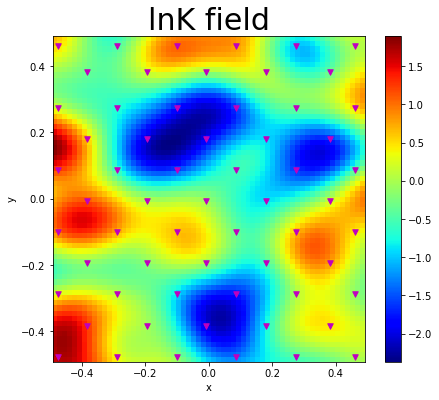

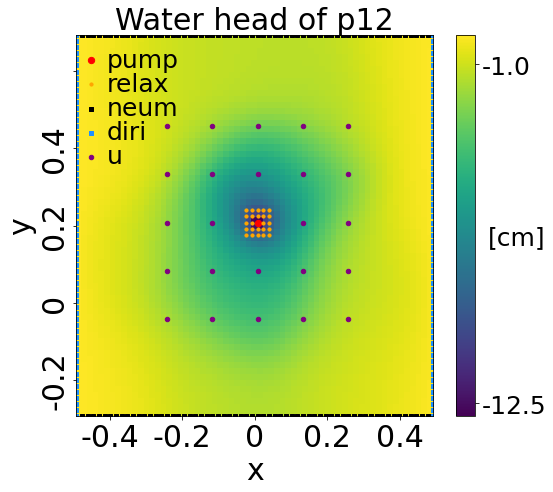

In [28]:
#################### set font size ####################
axis_label_font_size = 30
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 25
title_size = 30

################ show logK field ###################
fig2,ax2 = plt.subplots(figsize=(7,6))

im2 = ax2.pcolor(X,Y,logK, cmap='jet')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
fig2.colorbar(im2, ax=ax2, orientation='vertical')
ax2.scatter(X_star[K_measure_id,0], X_star[K_measure_id,1], marker='v', zorder=1, alpha= 1, c='m', s=30)
ax2.set_title("lnK field",fontsize=title_size)

################ show water heads under a pumping event (pe) ###################
pe = 12
head = heads[:,pe].reshape((nx,ny))

fig, ax = plt.subplots(1, 1, figsize=(8,7))
im = ax.pcolor(X,Y,head)

ax.scatter(X_star[pump_cell_idx[pe],0], X_star[pump_cell_idx[pe],1], marker="o", zorder=1, alpha= 1, c='r', s=40, label="pump")
ax.scatter(X_star[around_idx[pe],0], X_star[around_idx[pe],1], zorder=1, alpha= 1.0, c='orange', s=10, label="relax")
ax.scatter(X_star[ybound_idx,0], X_star[ybound_idx,1], marker='s', zorder=1, alpha= 1, c='k', s=20, label="neum")
ax.scatter(X_star[xbound_idx,0], X_star[xbound_idx,1], marker='s', zorder=1, alpha= 1, c='dodgerblue', s=20, label="diri")
ax.scatter(X_star[np.delete(pump_cell_idx,pe),0], X_star[np.delete(pump_cell_idx,pe),1], zorder=1, alpha= 1, c='purple', s=20, label="u")

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)
labels = [-0.4, -0.2, 0, 0.2, 0.4]
ax.set_xticks(labels)
ax.set_xticks(labels)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax.legend(loc='upper left',ncol=1,prop={'size': legend_fontszie}, framealpha=0, facecolor='none',borderpad=0.01,labelspacing=0.001,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

cbar = fig.colorbar(im, ax=ax,ticks=[-0.125, -0.010])
cbar.ax.set_ylabel('[cm]',labelpad=-30,rotation=0,va='top',size=25)
cbar.ax.set_yticklabels(['-12.5', '-1.0']) 
cbar.ax.tick_params(labelsize=colorbar_font_size) 
ax.set_title('Water head of p'+str(pe),fontsize=title_size)

In [29]:
############# create PINN instance #############

hnu = 20 # number of hidden unit in each layer of net u
hnK = 20 # number of hidden unit in each layer of net K

layers = [2, hnu, hnu, hnu, hnu, hnu, hnu, 1]
layers_K = [2, hnK, hnK, hnK, hnK, hnK, hnK, 1]

model =PhysicsInformedNN(layers,layers_K)

In [30]:
############# fixed data used for all nets ##########

############# K measurements ##########
K_star = K.flatten()[:,None]
K_train = K_star[K_measure_id]
X_K_train = X_star[K_measure_id]

# Domain bounds   
lbs = np.array([min(x),min(y)])
ubs = np.array([max(x),max(y)])
    
################### Dirichlet BCs (left & right bound)  ##########
N_diri = 64 # No. of point for Dirichlet BCs
# left (x=0) and right (x=1)
xx = X_star[xbound_idx]
uu = np.zeros((xx.shape[0],1))

X_diri_train = xx
diri_train = uu

################### Neumann BCs (top & bottom bound)  #############
N_neum = 64  # No. of points for Neumann BCs
# bottom (y = 0) and top (y=1)
yy = X_star[ybound_idx]
du = np.zeros((yy.shape[0],1))

X_neum_train = yy
neum_train = du

# transform data for network training
neum_data = model.data_loader(X_neum_train, neum_train, lbs, ubs)
diri_data = model.data_loader(X_diri_train, diri_train, lbs, ubs)
K_data = model.data_loader(X_K_train, K_train, lbs, ubs)

In [31]:
############# specific data in each individual pumping events ##########

Qp = 30   # approximated water amount changing rate in pumping grid

data_batch = []   # data batch containing training data

for jj in range(num_wells):

  # pump well and pump rate 
  X_pump_train = X_star[pump_cell_idx[jj]][None,:]
  pump_train = np.array([[Qp]])

  # water heads at monitor wells
  u_star = heads[:,jj][:,None]
  X_u_train = X_star[np.delete(pump_cell_idx,jj)]
  u_train = u_star[np.delete(pump_cell_idx,jj)]

  # cells outside pump (relax) region set for PDE constraints
  region_idx = np.hstack((pump_cell_idx[jj],around_idx[jj],xbound_idx,ybound_idx))
  X_f_space = np.delete(X_star, region_idx, 0)
  X_f_train = X_f_space[::1]
  f_train = np.zeros((X_f_train.shape[0],1))

  # transform data for network training
  f_data = model.data_loader(X_f_train, f_train, lbs, ubs)
  u_data = model.data_loader(X_u_train, u_train, lbs, ubs)
  pump_data = model.data_loader(X_pump_train, pump_train, lbs, ubs)

  # Assemble data batch of training data
  train_dict = {
    'neum': neum_data,
    'diri': diri_data,
    'u': u_data,
    'f': f_data,
    'K': K_data,
    'pump': pump_data
  }

  data_batch.append(train_dict)
  

In [32]:
# select pumping events for forward models
pump_id_list = [0, 4, 12, 20, 24]

npump = len(pump_id_list)


In [33]:
# # ########## load existing models ##############

# for i in pump_id_list:
#   params_u = np.loadtxt("./model_coeff/model_u_"+str(i)+".txt")
#   model.weights_u[i], model.biases_u[i] = model.load_NN(layers, params_u)

# params_K = np.loadtxt("./model_coeff/model_K.txt")
# model.weights_K, model.biases_K= model.load_NN(layers_K, params_K)


In [34]:
# hyper-parameters setup

# loss type aggregated in total loss
pred_ks = ['diri', 'neum', 'u', 'pump','f','K']

# weight of each loss term
loss_weights = {
  'f': 50.0,
  'u': 10000.0,
  'neum': 10000.0,
  'pump': 1.0,
  'K': 100.0,
  'diri': 20000.0
}

# networks coefficients to tune
biases_train = []
weights_train = []

for pid in pump_id_list:
  weights_train += model.weights_u[pid]
  biases_train += model.biases_u[pid]

biases_train += model.biases_K
weights_train += model.weights_K

# print out loss by interval = p_intervals
p_intervals = 3000

In [35]:
# training process

# define optimizer
optimizer = torch.optim.Adam(params=weights_train+biases_train, lr=1e-3)

start_time = time.time()
model.train(10001, data_batch, model.loss_func, optimizer, pred_ks, loss_weights, pump_id_list, p_intervals)

# update learn rate
optimizer.lt=1e-4
model.train(20000, data_batch, model.loss_func, optimizer, pred_ks, loss_weights, pump_id_list, p_intervals)

optimizer.lt=1e-5
model.train(20000, data_batch, model.loss_func, optimizer, pred_ks, loss_weights, pump_id_list, p_intervals)

elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


Iter # 1, Loss: 3237.86083984, Time: 0.6258
Pump 0: u:7.011870038695633; f:0.11165633331984282; K:159.3450427055359; neum:9.721330716274679; pump:396.59881591796875; diri:49.36465062201023; 
Pump 4: u:30.360808596014977; f:0.42011095210909843; K:159.3450427055359; neum:116.30787514150143; pump:406.5267333984375; diri:31.037176959216595; 
Pump 12: u:11.185589246451855; f:0.0758222071453929; K:159.3450427055359; neum:25.694542564451694; pump:399.8313293457031; diri:31.32973564788699; 
Pump 20: u:2.1426517923828214; f:0.006085551285650581; K:159.3450427055359; neum:8.07611271739006; pump:400.2257995605469; diri:14.068663585931063; 
Pump 24: u:2.963894803542644; f:0.08582515874877572; K:159.3450427055359; neum:69.04677953571081; pump:399.9932861328125; diri:28.94836012274027; 


KeyboardInterrupt: 

In [1]:
# relative residuals of forward models
X_pred= model.coor_shift(X_star, lbs, ubs)
error_u_list = []
for ti in pump_id_list:
  
  u_true = heads[:,ti]
  u_pred = model.predict(X_pred, pid=ti, target='u')
  u_err = u_pred-u_true
  error_u = np.linalg.norm(u_err,2)/np.linalg.norm(u_true,2)
  print('Relative residual of h of pump%d: %e' % (ti,error_u))
  error_u_list.append(error_u)

# print(error_u_list)
print("Min Err: ", min(error_u_list))
print("Max Err: ", max(error_u_list))
print("mean Err: ", np.mean(error_u_list))
print("std Err: ", np.std(error_u_list))

NameError: name 'model' is not defined

Text(0.5, 0.92, 'Predicted Water Heads')

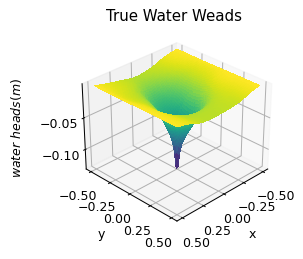

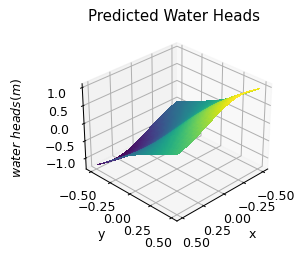

In [ ]:
################### water heads 3D surface ##################
#################### set font size ####################
axis_label_font_size = 10
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 25
title_size = 30

ti = pump_id_list[2]
X_pred= model.coor_shift(X_star, lbs, ubs)
u_true = heads[:,ti]
u_pred = model.predict(X_pred, pid=ti, target='u')

u_pred = u_pred.reshape((nx,ny))
u_true = u_true.reshape((nx,ny))

fig = plt.figure(figsize=(5,3), dpi=90)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,u_true, rstride=1, cstride=1, cmap='viridis',
        linewidth=0, antialiased=False)

ax.set_xlabel('x', fontsize=axis_label_font_size)
ax.set_ylabel('y', fontsize=axis_label_font_size)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('$water\ heads (m)$',fontsize=axis_label_font_size, labelpad=10, rotation=90)
ax.view_init(30,45)
ax.set_title('True Water Weads')

fig = plt.figure(figsize=(5,3), dpi=90)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X,Y,u_pred, rstride=1, cstride=1, cmap='viridis',
        linewidth=0, antialiased=False)

ax.set_xlabel('x', fontsize=axis_label_font_size)
ax.set_ylabel('y', fontsize=axis_label_font_size)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('$water\ heads (m)$',fontsize=axis_label_font_size, labelpad=10, rotation=90)
ax.view_init(30,45)
ax.set_title('Predicted Water Heads')

Relative residual of K: 8.334313e-01


C:\Users\qguo48\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
C:\Users\qguo48\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log
C:\Users\qguo48\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'Predicted logK Field')

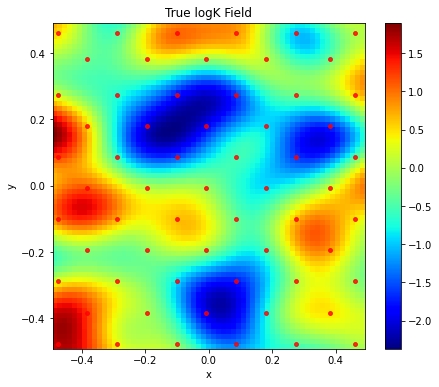

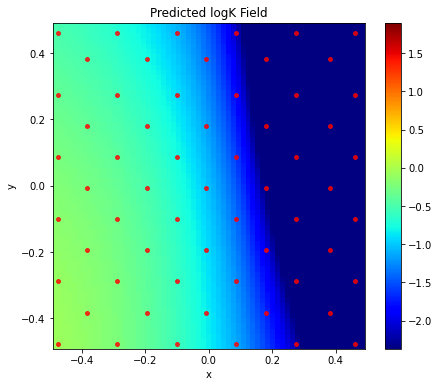

In [ ]:
# relative residuals of inverse model
K_pred = model.predict(X_pred, pid=ti, target='K')
K_true = K.flatten()

K_err = K_true - K_pred
error_K = np.linalg.norm(K_err,2)/np.linalg.norm(K_true,2)
print('Relative residual of K: %e' % (error_K))

################### hydraulic conductivity colormap 2D ##################
K_pred = K_pred.reshape((nx,ny))
minlK, maxlK = np.min(logK), np.max(logK)
fig,ax = plt.subplots(figsize=(7,6))
im = ax.pcolor(X,Y,logK,cmap='jet')
im.set_clim(minlK, maxlK )
fig.colorbar(im, ax=ax)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(X_star[K_measure_id,0], X_star[K_measure_id,1], zorder=1, alpha= 0.8, c='r', s=15)
ax.set_title('True logK Field')
logK_pred = np.nan_to_num(np.log(K_pred),nan=minlK)
fig,ax = plt.subplots(figsize=(7,6))
im = ax.pcolor(X,Y, logK_pred,cmap='jet')
im.set_clim(minlK, maxlK )

fig.colorbar(im, ax=ax)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(X_star[K_measure_id,0], X_star[K_measure_id,1], zorder=1, alpha= 0.8, c='r', s=15)
ax.set_title('Predicted logK Field')


In [ ]:
# accuracy of inverse model

thres = 0.1   # threshold 10%
K_len = maxlK-minlK

relative_abs_err = abs(logK-logK_pred)/K_len
accuracy = sum(sum(acc<thres))/(nx*ny)
print('Accuracy of K: %e' % (accuracy))

fig,ax = plt.subplots(figsize=(7,6))
plt.pcolor(X,Y,relative_abs_err,cmap=plt.cm.BuPu_r)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Relative Absolute Error of logK')

In [ ]:
############## save well-trained model: u and K ############
try:
  os.mkdir("./model_coeff")
except:
  FileExistsError
m = model
for i in pump_id_list:
  weights = torch.ones(1,hnu)*i

  for j in range(len(layers)-2):
    w = m.weights_u[i][j]
    b = m.biases_u[i][j]
    weights = torch.vstack((weights,w,b))

  weights = torch.vstack((weights,m.weights_u[i][j+1].T,torch.ones(1,hnu)*m.biases_u[i][j+1]))
  weights=weights.detach().numpy()


  path_name = "./model_coeff/model_u"+"_"+str(i)+".txt"
  np.savetxt(path_name,weights)

weights = torch.ones(1,hnK)*i

for j in range(len(layers)-2):
  w = m.weights_K[j]
  b = m.biases_K[j]
  weights = torch.vstack((weights,w,b))

weights = torch.vstack((weights,m.weights_K[j+1].T,torch.ones(1,hnK)*m.biases_K[j+1]))
weights=weights.detach().numpy()

path_name = "./model_coeff/model_K.txt"
np.savetxt(path_name,weights)

In [ ]:
############## save hyper-parameters for reproduce ##################
hyper_param = copy.copy(loss_weights)
hyper_param['Qp'] = Qp
hyper_param['r'] = r
hyper_param['hnK'] = hnK
hyper_param['hnu'] = hnu
hyper_param['lenK'] = len(layers_K)
hyper_param['lenu'] = len(layers)
hyper_param['act_K'] = 'tanh'
hyper_param['act_u'] = 'tanh'
hyper_param['out_K'] = 'linear'
hyper_param['out_u'] = 'linear'

f = open("./model_coeff/hyper_parameters_inverse.txt","w")
f.write(str(hyper_param))
f.close()